In [2]:
# PLOT SEGMENTS BEFORE DATALOADER HAS PROCESSED THEM

from paths import SPLITS_DIR
import pyarrow.parquet as pq

train_df = pq.read_table(SPLITS_DIR / 'train.parquet').to_pandas()
val_df = pq.read_table(SPLITS_DIR / 'val.parquet').to_pandas()
train_df = train_df.sort_values(['MMSI', 'segment_id', 'Timestamp']) # Ensure data is sorted properly
val_df = val_df.sort_values(['MMSI', 'segment_id', 'Timestamp']) # Ensure data is sorted properly

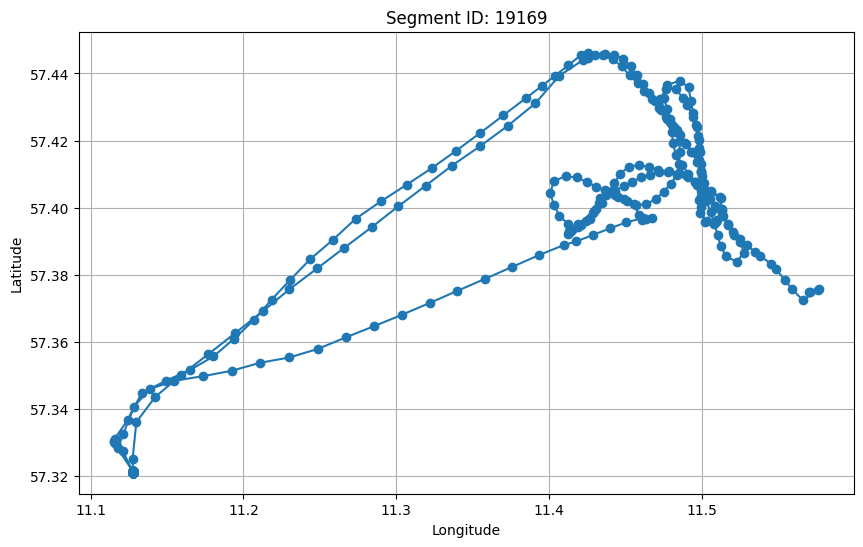

In [3]:
#visualize segment by plotting (only takes segment_id)
import matplotlib.pyplot as plt
def plot_segment(df, segment_id):
    segment = df[df['segment_id'] == segment_id]
    plt.figure(figsize=(10, 6))
    plt.plot(segment['Longitude'], segment['Latitude'], marker='o')
    plt.title(f'Segment ID: {segment_id}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()
    
plot_segment(train_df, 19169)

In [4]:
# PLOT SEGMENTS AFTER DATALOADER HAS PROCESSED THEM

from dataloader import load_train, load_val
from torch.utils.data import DataLoader

train_ds = load_train()
val_ds = load_val()

Initial data manipulation done, computing sliding windows and building x and y tensors . . .


100%|██████████| 59518/59518 [00:32<00:00, 1830.93it/s]


Built tensor lists
Built full tensors
torch.Size([3773409, 30, 4]) torch.Size([3773409, 10, 4])
Initial data manipulation done, computing sliding windows and building x and y tensors . . .


100%|██████████| 12847/12847 [00:05<00:00, 2532.49it/s]


Built tensor lists
Built full tensors
torch.Size([788039, 30, 4]) torch.Size([788039, 10, 4])


Smallest Latitude: 57.06410217285156, Biggest Latitude: 57.06418991088867
Smallest Longitude: 9.97065544128418, Biggest Longitude: 9.970870018005371
Longest distance between two points in the sequence: 0.013128288107219745 km


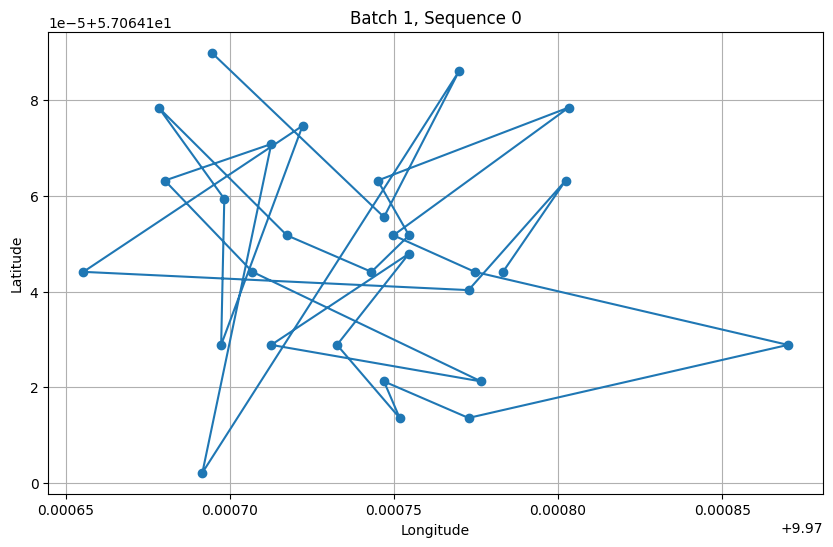

In [ ]:
# define dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

def plot_sequence_from_dataloader(dataloader, batch_idx, seq_idx):
    """
    Plot a single sequence from a specific batch in a DataLoader.
    Also print the smallest and biggest lat and long from the sequence 

    dataloader : PyTorch DataLoader
    batch_idx  : int, index of the batch in the dataloader
    seq_idx    : int, index of the sequence inside that batch 
    """
    for i, (x_batch, y_batch) in enumerate(dataloader):
        if i == batch_idx:
            # x_batch shape: [batch_size, seq_len, features]
            if seq_idx >= x_batch.shape[0]:
                raise ValueError(f"seq_idx {seq_idx} out of range for batch size {x_batch.shape[0]}")
            
            sequence = x_batch[seq_idx].cpu().numpy()  # shape [seq_len, features]

            latitudes = sequence[:, 0]
            longitudes = sequence[:, 1]
            print(f"Smallest Latitude: {latitudes.min()}, Biggest Latitude: {latitudes.max()}")
            print(f"Smallest Longitude: {longitudes.min()}, Biggest Longitude: {longitudes.max()}")

            #print the longest distance between two points in the sequence
            from geopy.distance import geodesic
            max_distance = 0
            for j in range(len(sequence)):
                for k in range(j + 1, len(sequence)):
                    point1 = (sequence[j, 0], sequence[j, 1])  # (Latitude, Longitude)
                    point2 = (sequence[k, 0], sequence[k, 1])  # (Latitude, Longitude)
                    distance = geodesic(point1, point2).kilometers
                    if distance > max_distance:
                        max_distance = distance
            print(f"Longest distance between two points in the sequence: {max_distance} km")
            
            plt.figure(figsize=(10, 6))
            plt.plot(sequence[:, 1], sequence[:, 0], marker='o')  # Longitude vs Latitude
            plt.title(f'Batch {batch_idx}, Sequence {seq_idx}')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.grid()
            plt.show()
            return
    
    raise ValueError(f"batch_idx {batch_idx} out of range for dataloader (total batches unknown until iterated)")

plot_sequence_from_dataloader(train_loader, batch_idx=1, seq_idx=0)


In [11]:
import numpy as np
from tqdm import tqdm

def haversine_np(lat1, lon1, lat2, lon2):
    # all in radians
    R = 6371000  # Earth radius in meters
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

close_count = 0

for x_batch, y_batch in tqdm(train_loader):
    # x_batch shape: [batch_size, seq_len, features]
    latitudes = x_batch[:, :, 0].numpy()  # [batch_size, seq_len]
    longitudes = x_batch[:, :, 1].numpy()  # [batch_size, seq_len]

    # convert degrees to radians for Haversine
    lat_rad = np.radians(latitudes)
    lon_rad = np.radians(longitudes)

    for seq_lat, seq_lon in zip(lat_rad, lon_rad):
        # compute all pairwise distances using broadcasting
        dlat = seq_lat[:, None] - seq_lat[None, :]
        dlon = seq_lon[:, None] - seq_lon[None, :]
        a = np.sin(dlat / 2)**2 + np.cos(seq_lat[:, None]) * np.cos(seq_lat[None, :]) * np.sin(dlon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        distances = 6371000 * c  # in meters
        max_distance = np.max(distances)
        if max_distance < 20:
            close_count += 1

total_batches = len(train_loader)
total_sequences = total_batches * train_loader.batch_size

print(f"Sequences with all points closer than 20 meters: {close_count} out of {total_sequences}")
print(f"Percentage: {close_count / total_sequences * 100:.2f}%")


100%|██████████| 117920/117920 [00:59<00:00, 1987.25it/s]

Sequences with all points closer than 20 meters: 1234727 out of 3773440
Percentage: 32.72%


In [10]:
# find out how many of the batches we have where all langitude and longitude points are very close to each other

close_count = 0

for i, (x_batch, y_batch) in enumerate(train_loader):
    longitudes = x_batch[:, :, 1]  # shape [batch_size, seq_len]
    latitudes = x_batch[:, :, 0]   # shape [batch_size, seq_len]
    
    long_diff = longitudes.max(dim=1).values - longitudes.min(dim=1).values
    lat_diff = latitudes.max(dim=1).values - latitudes.min(dim=1).values
    
    # this is equal to 
    close_mask = (long_diff < 0.001) & (lat_diff < 0.001)
    close_count += close_mask.sum().item()

print(f"Number of sequences with very close longitude and latitude points: {close_count}")
#total number of batches in train_loader
total_batches = len(train_loader)
#total number of sequences in train_loader
total_sequences = total_batches * train_loader.batch_size
print(f"Total number of sequences in train_loader: {total_sequences}")
print(close_count/total_sequences * 100, "% of sequences have very close longitude and latitude points")


Number of sequences with very close longitude and latitude points: 1419230
Total number of sequences in train_loader: 3773440
37.611039263907735 % of sequences have very close longitude and latitude points


In [ ]:
# print COG and SOG values for 10 random sequences in the train_loader
import random
for _ in range(10):
    batch_idx = random.randint(0, len(train_loader)-1)
    seq_idx = random.randint(0, train_loader.batch_size-1)
    for i, (x_batch, y_batch) in enumerate(train_loader):
        if i == batch_idx:
            if seq_idx >= x_batch.shape[0]:
                raise ValueError(f"seq_idx {seq_idx} out of range for batch size {x_batch.shape[0]}")
            sequence = x_batch[seq_idx].cpu().numpy()  # shape [seq_len, features]
            sog = sequence[:, 2]
            cog = sequence[:, 3]
            print(f"Batch {batch_idx}, Sequence {seq_idx}")
            print("SOG:", sog)
            print("COG:", cog)
            print()
            break

Batch 84660, Sequence 29
SOG: [5.2473288 5.195884  5.195884  5.195884  5.195884  5.14444   5.14444
 5.14444   5.14444   5.0929956 5.0929956 5.0929956 5.041551  5.041551
 4.9901066 5.0929956 5.0929956 5.14444   5.0929956 5.14444   5.14444
 5.195884  5.2473288 5.2473288 5.195884  4.9901066 5.195884  5.0929956
 4.9901066 4.9386625]
COG: [ 91.5  91.9  90.1  91.8  91.3  91.4  91.9  92.7  92.8  92.4  91.7  90.2
  89.7  89.1 108.2 107.4 107.8 108.6 108.8 107.1 108.8 107.9 107.4 108.1
 105.9 109.3 105.  106.9 107.3 108. ]

Batch 35681, Sequence 31
SOG: [2.7265532 2.5207756 2.57222   2.7265532 2.7779975 2.7265532 2.6236644
 1.2346656 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.0514444
 0.        0.       ]
COG: [329.5 326.5 320.7 318.9 327.5 323.7 291.  198.3  85.8   0.    0.    0.
  82.1  82.1 114.6   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.   